## Carga de librerías básicas

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

# 1. Cargar el conjunto de datos

El conjunto de datos de reseñas de películas de IMDB es el conjunto de datos para la clasificación binaria de sentimientos. Contiene 25 000 reseñas de películas altamente polarizadas para entrenamiento y 25 000 para pruebas. Este conjunto de datos se puede obtener de este sitio web o también se puede usar la biblioteca tensorflow_datasets.

In [2]:
# Obtain the imdb review dataset from tensorflow datasets
dataset = tfds.load('imdb_reviews', as_supervised=True)

# Seperate test and train datasets
train_dataset, test_dataset = dataset['train'], dataset['test']

# Split the test and train data into batches of 32
# and shuffling the training set
batch_size = 32
train_dataset = train_dataset.shuffle(10000)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.1J0M38_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.1J0M38_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.1J0M38_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


El código carga el conjunto de datos de reseñas de IMDb mediante conjuntos de datos de TensorFlow (tfds.load(‘imdb_reviews’, as_supervised=True)). A continuación, divide el conjunto de datos en conjuntos de entrenamiento y de prueba (train_dataset y test_dataset). Finalmente, agrupa los datos de entrenamiento y de prueba en conjuntos de 32 muestras cada uno y reorganiza el conjunto de entrenamiento para optimizar el proceso de aprendizaje, evitando que el modelo memorice el orden de las muestras de entrenamiento. La variable batch_size determina el tamaño de cada lote.

Impresión de una reseña de muestra y su etiqueta desde el conjunto de entrenamiento.

In [3]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b'This movie is extremely boring, it tells a story of a female gas station owner and her life. Nothing exciting ever happens. The director has really "kept it real" and it feels just like a camera following a woman around as she lives her life. I had to watch other films by this director for a class, the others were not as boring. This film was also watched for an assignment...it better be worth the boringness with a good grade!! Overall, unless it\'s required, don\'t watch the film. But don\'t discount other films by this director, because they\'re not as bad...and don\'t discount other films about Africa, they\'re usually good, especially when done by a western director.'

Label:  0


El código utiliza la función iter para crear un iterador para el conjunto de datos de entrenamiento y luego extrae el primer lote mediante next(iter(train_dataset)). Imprime el texto del primer ejemplo del lote (example.numpy()[0]) y su etiqueta correspondiente (label.numpy()[0]). Esto ofrece una idea del formato de los datos de entrenamiento, lo que ayuda a comprender cómo se estructuran el texto y las etiquetas en el conjunto de datos de reseñas de IMDb.

## 2. Construir el Modelo

En esta sección, definiremos el modelo que utilizaremos para el análisis de sentimientos. La capa inicial de esta arquitectura es la capa de vectorización de texto, responsable de codificar el texto de entrada en una secuencia de índices de tokens. Estos tokens se introducen posteriormente en la capa de incrustación, donde a cada palabra se le asigna un vector entrenable. Tras un entrenamiento suficiente, estos vectores tienden a ajustarse de forma que las palabras con significados similares tengan vectores similares. Estos datos se pasan a las capas de RNN, que procesan estas secuencias y finalmente las convierten en un único logit como salida de la clasificación.

Vectorización de Texto
Primero, realizaremos la vectorización de texto y dejaremos que el codificador asigne todas las palabras del conjunto de datos de entrenamiento a un token. En el siguiente ejemplo, también podemos ver cómo podemos codificar y decodificar la reseña de muestra en un vector de números enteros.

In [4]:
# Using the TextVectorization layer to normalize, split, and map strings to integers.
encoder = tf.keras.layers.TextVectorization(max_tokens=10000, output_sequence_length=250)
texts = [text.numpy().decode('utf-8') for text, _ in train_dataset.unbatch()]
encoder.adapt(texts)

# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())

# Encoding a test example and decoding it back.
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b'This movie is extremely boring, it tells a story of a female gas station owner and her life. Nothing exciting ever happens. The director has really "kept it real" and it feels just like a camera following a woman around as she lives her life. I had to watch other films by this director for a class, the others were not as boring. This film was also watched for an assignment...it better be worth the boringness with a good grade!! Overall, unless it\'s required, don\'t watch the film. But don\'t discount other films by this director, because they\'re not as bad...and don\'t discount other films about Africa, they\'re usually good, especially when done by a western director.'
encoded:  [  11   18    7  554  356    9  686    4   64    5    4  653 2596 1701
 2027    3   40  119  158 1120  122  557    2  172   44   63  794    9
  146    3    9  732   41   39    4  385 1032    4  246  184   15   55
  457   40  119   10   67    6  104   81   95   33   11  172   16    4
  802    2  

El código define una capa TextVectorization (codificador) con un límite de tamaño de vocabulario de 10 000 tokens y la adapta al conjunto de datos de entrenamiento. A continuación, extrae el vocabulario de la capa TextVectorization. El código codifica un texto de ejemplo utilizando la capa TextVectorization (encoder(original_text).numpy()) y lo decodifica a su forma original utilizando dicho vocabulario. Esto demuestra cómo la capa TextVectorization puede normalizar, tokenizar y mapear cadenas a enteros, lo que facilita el procesamiento de texto para modelos de aprendizaje automático.

Crear el modelo
Ahora, utilizaremos este codificador entrenado junto con otras capas para definir un modelo, como se explicó anteriormente. En TensorFlow, si bien las capas RNN no se pueden utilizar directamente con un contenedor bidireccional y una capa de incrustación, sí podemos emplear sus derivados, como LSTM (Memoria a Largo Plazo y Corto Plazo) y GRU (Unidad Recurrente Controlada). En este ejemplo, utilizaremos capas LSTM para definir el modelo.

In [5]:
# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


# Summary of the model
model.summary()

# Compile the model
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 250)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 250, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

El código define un modelo secuencial utilizando la API Keras de TensorFlow. Incluye una capa de vectorización de texto (codificador) para la tokenización, una capa de incrustación con 64 unidades, dos capas LSTM bidireccionales con 64 y 32 unidades, respectivamente, una capa densa con 64 unidades y activación ReLU, y una capa densa final con una sola unidad para la clasificación binaria. El modelo se compila utilizando la pérdida de entropía cruzada binaria, el optimizador Adam y la precisión como métrica de evaluación. El resumen ofrece una visión general de la arquitectura del modelo, mostrando las capas y sus parámetros.

## 3. Entrenamiento del modelo
Ahora, entrenaremos el modelo definido en el paso anterior.

In [6]:
# Training the model and validating it on test set
history = model.fit(
	train_dataset,
	epochs=5,
	validation_data=test_dataset,
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.6784 - loss: 0.5458 - val_accuracy: 0.8485 - val_loss: 0.3779
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.8964 - loss: 0.2447 - val_accuracy: 0.8370 - val_loss: 0.3762
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.9401 - loss: 0.1587 - val_accuracy: 0.8482 - val_loss: 0.4673
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9666 - loss: 0.0885 - val_accuracy: 0.8426 - val_loss: 0.4875
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/step - accuracy: 0.9819 - loss: 0.0489 - val_accuracy: 0.8402 - val_loss: 0.5943


El código entrena el modelo definido (modelo) utilizando el conjunto de datos de entrenamiento (train_dataset) durante 5 épocas. También valida el modelo en el conjunto de datos de prueba (test_dataset). Las métricas de progreso y rendimiento del entrenamiento se almacenan en la variable history para su posterior análisis o visualización.

## 4. Representación gráfica de los resultados
Representación gráfica de precisión y pérdida de entrenamiento y validación.

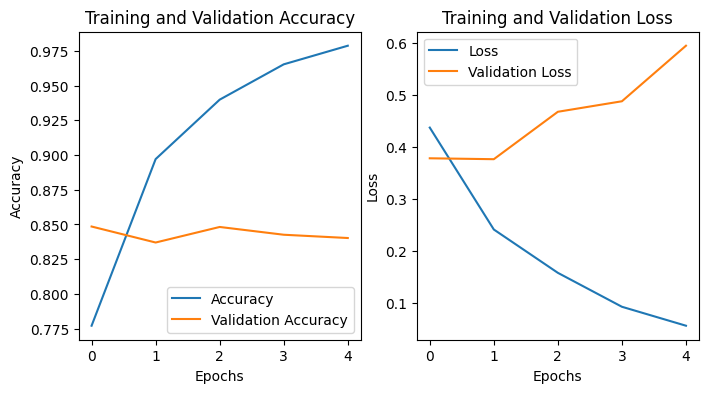

In [7]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()


El código visualiza la precisión del entrenamiento y la validación, así como su pérdida a lo largo de las épocas. Extrae los valores de precisión y pérdida del historial de entrenamiento (history_dict). La biblioteca matplotlib se utiliza para crear una subgráfica paralela, donde la izquierda muestra las tendencias de precisión y la derecha, las tendencias de pérdida a lo largo de las épocas.

##5. Prueba del modelo entrenado
Ahora, probaremos el modelo entrenado con una revisión aleatoria y comprobaremos su resultado.

In [8]:
# Making predictions
sample_text = (
	'''The movie by GeeksforGeeks was so good and the animation are so dope.
	I would recommend my friends to watch it.'''
)
predictions = model.predict(np.array([sample_text]))
print(*predictions[0])

# Print the label based on the prediction
if predictions[0] > 0:
	print('The review is positive')
else:
	print('The review is negative')


ValueError: Invalid dtype: str3584

El código realiza predicciones sobre un texto de muestra utilizando el modelo entrenado (model.predict(np.array([sample_text]))). El resultado (predictions[0]) representa la confianza del modelo en el sentimiento, donde los valores positivos indican un sentimiento positivo y los negativos, uno negativo. La sentencia condicional posterior interpreta la predicción, mostrando «La reseña es positiva» o «La reseña es negativa» según la clasificación del modelo.